In [1]:
import os, glob, tqdm
from skimage.io import imread, imsave
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib as mpl
import scipy.ndimage as ndi
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import normalized_root_mse as nrmse
import skimage.morphology as morph
from scipy.fftpack import dct
from skimage import exposure
# import cv2
plt.rcParams.update({'font.size': 15})
rc('font', size=12)
rc('font', family='Arial')
# plt.style.use('dark_background')
rc('pdf', fonttype=42)


In [2]:
def compute_image_information(patch):

    _dct = dct(dct(dct(patch).transpose(0,2,1)).transpose(1,2,0)).transpose(1,2,0).transpose(0,2,1)
    _dct = _dct**2/(_dct.shape[0]*_dct.shape[1]*_dct.shape[2])
    _dct = _dct/np.sum(_dct)
    _dct = _dct.flatten()
    entropy = -np.sum(_dct*np.log2(1e-6+_dct))
    
    return entropy


In [28]:
#####
# kdrl
#####
fname = os.path.join('..','kdrlGFP_3-4-5dpf_AF800_2020-11-20','3dpf','fish1_2020-11-20','analysis','corr_ssim.npz')
quant = np.load(fname)
corrs = quant['arr_0']
ssims = quant['arr_1']
nrmses = quant['arr_2']
info_gfp = quant['arr_3']
info_ir = quant['arr_4']
fname = glob.glob(os.path.join('..','kdrlGFP_3-4-5dpf_AF800_2020-11-20','3dpf','fish1_2020-11-20','DataSet','*.npz'))[0]
coordsAll = np.load(fname)['coordsAll']
z = coordsAll[:,0]
y = coordsAll[:,1]
x = coordsAll[:,2]

df1 = pd.DataFrame({'sampletype':'kdrlGFP',
                    'fishname':os.path.join('..','kdrlGFP_3-4-5dpf_AF800_2020-11-20','3dpf','fish1_2020-11-20'),
                    'corr':corrs,'ssim':ssims,'nrmse':nrmses,
                    'info_gfp':info_gfp,'info_ir':info_ir,'Z':z,'Y':y,'X':x})

#####
# h2bGFP
#####
fname = os.path.join('..','h2bGFP_2-3-4dpf_nGFP-CF800_new','4dpf','fish1_2021-04-14','analysis','corr_ssim.npz')
quant = np.load(fname)
corrs = quant['arr_0']
ssims = quant['arr_1']
nrmses = quant['arr_2']
info_gfp = quant['arr_3']
info_ir = quant['arr_4']
fname = glob.glob(os.path.join('..','h2bGFP_2-3-4dpf_nGFP-CF800_new','4dpf','fish1_2021-04-14','DataSet','*.npz'))[0]
coordsAll = np.load(fname)['coordsAll']
z = coordsAll[:,0]
y = coordsAll[:,1]
x = coordsAll[:,2]

df2 = pd.DataFrame({'sampletype':'h2bGFP',
                    'fishname':os.path.join('..','h2bGFP_2-3-4dpf_nGFP-CF800_new','4dpf','fish1_2021-04-14'),
                    'corr':corrs,'ssim':ssims,'nrmse':nrmses,
                    'info_gfp':info_gfp,'info_ir':info_ir,'Z':z,'Y':y,'X':x})


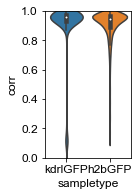

In [95]:
df = pd.concat([df1,df2], axis=0)

fig, ax = plt.subplots(figsize=(2,3))
fig.subplots_adjust(left=0.3, bottom=0.2)
sns.violinplot(data=df, x='sampletype', y='corr', ax=ax)
# sns.boxplot(data=df, x='sample', y='corr', showfliers= False, ax=ax)
# sns.swarmplot(data=df, x='sample', y='corr', ax=ax, color='k', s=2)
ax.set_ylim(0,1.)

fig.savefig('corr.pdf')

(0.5, 1.0)

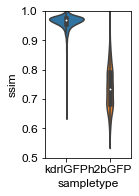

In [30]:
fig, ax = plt.subplots(figsize=(2,3))
fig.subplots_adjust(left=0.3, bottom=0.2)
sns.violinplot(data=df, x='sampletype', y='ssim', ax=ax)
# sns.boxplot(data=df, x='sample', y='ssim', showfliers= False, ax=ax)
# sns.swarmplot(data=df, x='sample', y='ssim', ax=ax, color='k', s=2)
ax.set_ylim(0.5,1.)

Text(0, 0.5, 'Info')

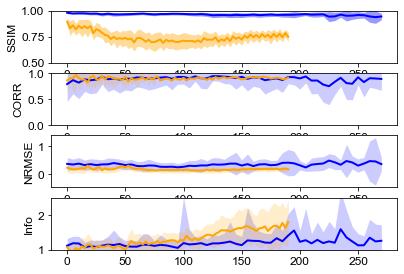

In [31]:
df3 = df1#[(df1['corr']>0.6)&(df2['nrmse']<0.4)]
df3.Z = df3.Z-np.min(df3.Z)
zstep=5

corr_depth = []
corr_depth_std = []
ssim_depth = []
ssim_depth_std = []
nrmse_depth = []
nrmse_depth_std = []
info_depth = []
info_depth_std = []
zrange = np.arange(np.min(df3.Z),np.max(df3.Z)+1)
for z in zrange:
    dfz = df3[df3.Z==z]
    corr_depth.append(np.mean(dfz['corr']))
    corr_depth_std.append(np.std(dfz['corr']))
    
    ssim_depth.append(np.mean(dfz['ssim']))
    ssim_depth_std.append(np.std(dfz['ssim']))
    
    nrmse_depth.append(np.mean(dfz['nrmse']))
    nrmse_depth_std.append(np.std(dfz['nrmse']))

    info_depth.append(np.mean(dfz['info_ir']/dfz['info_gfp']))
    info_depth_std.append(np.std(dfz['info_ir']/dfz['info_gfp']))#/np.sqrt(len(dfz)))

ssim_depth = np.array(ssim_depth)
ssim_depth_std = np.array(ssim_depth_std)
corr_depth = np.array(corr_depth)
corr_depth_std = np.array(corr_depth_std)
nrmse_depth = np.array(nrmse_depth)
nrmse_depth_std = np.array(nrmse_depth_std)
info_depth = np.array(info_depth)
info_depth_std = np.array(info_depth_std)

fig, ax = plt.subplots(nrows=4)
fig.subplots_adjust(left=0.1, bottom=0.05)

# ax[0].scatter(df3.Z,df3.ssim,s=1,c='k',alpha=0.2,rasterized=True)
ax[0].fill_between(zrange*zstep,ssim_depth-ssim_depth_std,ssim_depth+ssim_depth_std,alpha=0.4,color='b', linewidth=0.0)
ax[0].plot(zrange*zstep,ssim_depth,'-b',lw=2)
# ax[0].set_ylim(0.5,1)

# ax[1].scatter(df3.Z,df3['corr'],s=1,c='k',alpha=0.2,rasterized=True)
ax[1].fill_between(zrange*zstep,corr_depth-corr_depth_std,corr_depth+corr_depth_std,alpha=0.2,color='b', linewidth=0.0)
ax[1].plot(zrange*zstep,corr_depth,'-b',lw=2)
# ax[1].set_ylim(0.5,1)

# ax[2].scatter(df3.Z,df3['nrmse'],s=1,c='k',alpha=0.2,rasterized=True)
ax[2].fill_between(zrange*zstep,nrmse_depth-nrmse_depth_std,nrmse_depth+nrmse_depth_std,alpha=0.2,color='b', linewidth=0.0)
ax[2].plot(zrange*zstep,nrmse_depth,'-b',lw=2)
# ax[2].set_ylim(0,1)

# ax[4].scatter(df3.Z,df3['info_ir'],s=1,c='k',alpha=0.2,rasterized=True)
# ax[4].fill_between(zrange,info_ir_depth-info_ir_depth_std,info_ir_depth+info_ir_depth_std,alpha=0.2,color='r')
# ax[4].fill_between(zrange,info_gfp_depth-info_gfp_depth_std,info_gfp_depth+info_gfp_depth_std,alpha=0.2,color='b')
# ax[4].plot(zrange,info_gfp_depth,'-b',lw=2)
# ax[4].plot(zrange,info_ir_depth,'-r',lw=2)
ax[3].plot(zrange*zstep, info_depth,lw=2,color='b')
ax[3].fill_between(zrange*zstep,info_depth-info_depth_std,info_depth+info_depth_std,alpha=0.2,color='b', linewidth=0.0)
# ax[4].set_ylim(0,1.5)

df3 = df2#[(df2['corr']>0.6)&(df2['nrmse']<0.4)]
df3.Z = df3.Z-np.min(df3.Z)
zstep=2.5

corr_depth = []
corr_depth_std = []
ssim_depth = []
ssim_depth_std = []
nrmse_depth = []
nrmse_depth_std = []
info_depth = []
info_depth_std = []
zrange = np.arange(np.min(df3.Z),np.max(df3.Z)+1)
for z in zrange:
    dfz = df3[df3.Z==z]
    corr_depth.append(np.mean(dfz['corr']))
    corr_depth_std.append(np.std(dfz['corr']))
    
    ssim_depth.append(np.mean(dfz['ssim']))
    ssim_depth_std.append(np.std(dfz['ssim']))
    
    nrmse_depth.append(np.mean(dfz['nrmse']))
    nrmse_depth_std.append(np.std(dfz['nrmse']))

    info_depth.append(np.mean(dfz['info_ir']/dfz['info_gfp']))
    info_depth_std.append(np.std(dfz['info_ir']/dfz['info_gfp']))#/np.sqrt(len(dfz)))

ssim_depth = np.array(ssim_depth)
ssim_depth_std = np.array(ssim_depth_std)
corr_depth = np.array(corr_depth)
corr_depth_std = np.array(corr_depth_std)
nrmse_depth = np.array(nrmse_depth)
nrmse_depth_std = np.array(nrmse_depth_std)
info_depth = np.array(info_depth)
info_depth_std = np.array(info_depth_std)

# ssim_depth = ssim_depth/ssim_depth[0]
# ssim_depth_std = ssim_depth_std/ssim_depth[0]
# corr_depth = corr_depth/corr_depth[0]
# corr_depth_std = corr_depth_std/corr_depth[0]
# nrmse_depth = nrmse_depth/nrmse_depth[0]
# nrmse_depth_std = nrmse_depth_std/nrmse_depth[0]

# ax[0].scatter(df3.Z,df3.ssim,s=1,c='k',alpha=0.2,rasterized=True)
ax[0].fill_between(zrange*zstep,ssim_depth-ssim_depth_std,ssim_depth+ssim_depth_std,alpha=0.4,color='orange', linewidth=0.0)
ax[0].plot(zrange*zstep,ssim_depth,'-',lw=2,color='orange')
ax[0].set_ylim(0.5,1)

# ax[1].scatter(df3.Z,df3['corr'],s=1,c='k',alpha=0.2,rasterized=True)
ax[1].fill_between(zrange,corr_depth-corr_depth_std,corr_depth+corr_depth_std,alpha=0.2,color='orange', linewidth=0.0)
ax[1].plot(zrange*zstep,corr_depth,'-',lw=2,color='orange')
ax[1].set_ylim(0.,1)

# ax[2].scatter(df3.Z,df3['nrmse'],s=1,c='k',alpha=0.2,rasterized=True)
ax[2].fill_between(zrange*zstep,nrmse_depth-nrmse_depth_std,nrmse_depth+nrmse_depth_std,alpha=0.2,color='orange', linewidth=0.0)
ax[2].plot(zrange*zstep,nrmse_depth,'-',lw=2,color='orange')
# ax[2].set_ylim(0,1)

# ax[4].scatter(df3.Z,df3['info_ir'],s=1,c='k',alpha=0.2,rasterized=True)
# ax[4].fill_between(zrange,info_ir_depth-info_ir_depth_std,info_ir_depth+info_ir_depth_std,alpha=0.2,color='r')
# ax[4].fill_between(zrange,info_gfp_depth-info_gfp_depth_std,info_gfp_depth+info_gfp_depth_std,alpha=0.2,color='b')
# ax[4].plot(zrange,info_gfp_depth,'-b',lw=2)
# ax[4].plot(zrange,info_ir_depth,'-r',lw=2)
ax[3].plot(zrange*zstep, info_depth,lw=2,color='orange')
ax[3].fill_between(zrange*zstep,info_depth-info_depth_std,info_depth+info_depth_std,alpha=0.2,color='orange', linewidth=0.0)
ax[3].set_ylim(1.,2.5)

ax[0].set_ylabel('SSIM')
ax[1].set_ylabel('CORR')
ax[2].set_ylabel('NRMSE')
ax[3].set_ylabel('Info')


In [32]:
df

,sampletype,fishname,corr,ssim,nrmse,info_gfp,info_ir,Z,Y,X
0,kdrlGFP,..\kdrlGFP_3-4-5dpf_AF800_2020-11-20\3dpf\fish...,0.964265,0.948454,0.474002,0.660840,1.057607,65,1540,1116
1,kdrlGFP,..\kdrlGFP_3-4-5dpf_AF800_2020-11-20\3dpf\fish...,0.131206,0.973285,0.793103,0.265572,0.437220,79,834,1611
2,kdrlGFP,..\kdrlGFP_3-4-5dpf_AF800_2020-11-20\3dpf\fish...,0.983219,0.967900,0.116316,1.930764,2.111880,65,1298,1149
3,kdrlGFP,..\kdrlGFP_3-4-5dpf_AF800_2020-11-20\3dpf\fish...,0.937333,0.978551,0.201569,2.331920,2.169278,59,1046,980
4,kdrlGFP,..\kdrlGFP_3-4-5dpf_AF800_2020-11-20\3dpf\fish...,0.885083,0.923223,0.470103,2.287699,2.354316,72,1156,1067
...,...,...,...,...,...,...,...,...,...,...
3589,h2bGFP,..\h2bGFP_2-3-4dpf_nGFP-CF800_new\4dpf\fish1_2...,0.966342,0.727219,0.208719,0.242890,0.516798,87,1571,642
3590,h2bGFP,..\h2bGFP_2-3-4dpf_nGFP-CF800_new\4dpf\fish1_2...,0.963723,0.623230,0.096004,0.101634,0.106621,48,1823,706
3591,h2bGFP,..\h2bGFP_2-3-4dpf_nGFP-CF800_new\4dpf\fish1_2...,0.984874,0.753805,0.130574,0.726966,0.766437,50,1638,1459
3592,h2bGFP,..\h2bGFP_2-3-4dpf_nGFP-CF800_new\4dpf\fish1_2...,0.928383,0.694173,0.085084,0.079818,0.093459,46,1382,1373


# Show low corr patches are noise

## kdrlGFP

In [99]:
# load images
fish_folder = df1.fishname.values[0]

flist = glob.glob(os.path.join(fish_folder,'*.tif'))
flist.sort()

gfp = imread(flist[0])
ir = imread(flist[1])

irir = imread(os.path.join(fish_folder,
                           'restored_with_model_3dpf_4fish_patches32x128x128_2layers',
                           'restoredFull_csbdeep','restored.tif'))[0]

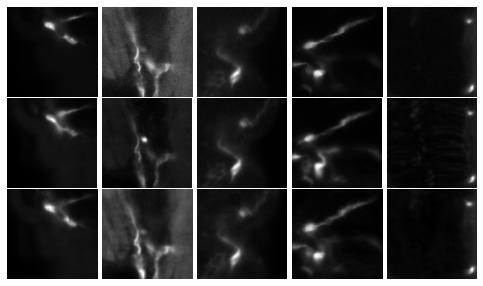

In [129]:
N = 5
high = df1[df1['corr']>0.8]#.nlargest(N, columns=['corr'])
high = high.sample(N)

fig, ax = plt.subplots(3,N,figsize=(8.5,5))
fig.subplots_adjust(wspace=0,hspace=0.01)

j=0
for i, row in high.iterrows():
    
    gfp_p = gfp[row.Z,row.Y-64:row.Y+64,row.X-64:row.X+64]
    ir_p = ir[row.Z,row.Y-64:row.Y+64,row.X-64:row.X+64]
    irir_p = irir[row.Z,row.Y-64:row.Y+64,row.X-64:row.X+64]
    
    ax[0,j].imshow(gfp_p, cmap='gray')
    ax[1,j].imshow(ir_p, cmap='gray')
    ax[2,j].imshow(irir_p, cmap='gray')

    ax[0,j].set_axis_off()
    ax[1,j].set_axis_off()
    ax[2,j].set_axis_off()
    
    j+=1
    
fig.savefig('kdrl_high_corr.pdf')

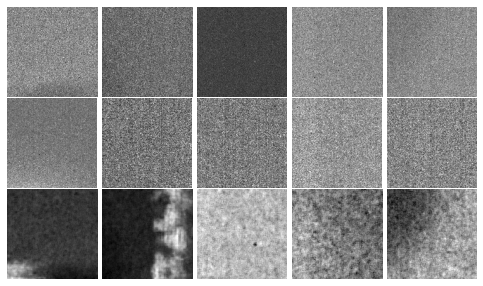

In [131]:
N = 5
low = df1[df1['corr']<0.2]#.nsmallest(N, columns=['corr'])
low = low.sample(N)

fig, ax = plt.subplots(3,N,figsize=(8.5,5))
fig.subplots_adjust(wspace=0,hspace=0.01)

j=0
for i, row in low.iterrows():
    
    gfp_p = gfp[row.Z,row.Y-64:row.Y+64,row.X-64:row.X+64]
    ir_p = ir[row.Z,row.Y-64:row.Y+64,row.X-64:row.X+64]
    irir_p = irir[row.Z,row.Y-64:row.Y+64,row.X-64:row.X+64]
    
    ax[0,j].imshow(gfp_p, cmap='gray')
    ax[1,j].imshow(ir_p, cmap='gray')
    ax[2,j].imshow(irir_p, cmap='gray')
    
    ax[0,j].set_axis_off()
    ax[1,j].set_axis_off()
    ax[2,j].set_axis_off()
    
    j+=1
    
fig.savefig('kdrl_low_corr.pdf')

## h2bGFP

In [132]:
# load images
fish_folder = df2.fishname.values[0]

flist = glob.glob(os.path.join(fish_folder,'*.tif'))
flist.sort()

gfp = imread(flist[0])
ir = imread(flist[1])

irir = imread(os.path.join(fish_folder,
                           'restored_with_model_2dpf_1fish_patches32x128x128_2layers',
                           'restoredFull_csbdeep','restored.tif'))[0]

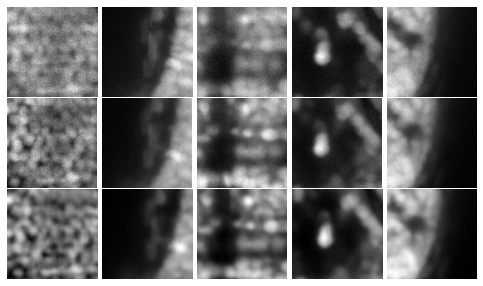

In [135]:
N = 5
high = df2[df2['corr']>0.8]
high = high.sample(N)

fig, ax = plt.subplots(3,N,figsize=(8.5,5))
fig.subplots_adjust(wspace=0,hspace=0.01)

j=0
for i, row in high.iterrows():
    
    gfp_p = gfp[row.Z,row.Y-64:row.Y+64,row.X-64:row.X+64]
    ir_p = ir[row.Z,row.Y-64:row.Y+64,row.X-64:row.X+64]
    irir_p = irir[row.Z,row.Y-64:row.Y+64,row.X-64:row.X+64]
    
    ax[0,j].imshow(gfp_p, cmap='gray')
    ax[1,j].imshow(ir_p, cmap='gray')
    ax[2,j].imshow(irir_p, cmap='gray')

    ax[0,j].set_axis_off()
    ax[1,j].set_axis_off()
    ax[2,j].set_axis_off()
    
    j+=1
    
fig.savefig('h2b_high_corr.pdf')

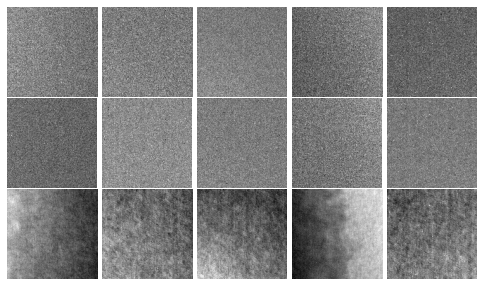

In [136]:
N = 5
low = df2[df2['corr']<0.2]
low = low.sample(N)

fig, ax = plt.subplots(3,N,figsize=(8.5,5))
fig.subplots_adjust(wspace=0,hspace=0.01)

j=0
for i, row in low.iterrows():
    
    gfp_p = gfp[row.Z,row.Y-64:row.Y+64,row.X-64:row.X+64]
    ir_p = ir[row.Z,row.Y-64:row.Y+64,row.X-64:row.X+64]
    irir_p = irir[row.Z,row.Y-64:row.Y+64,row.X-64:row.X+64]
    
    ax[0,j].imshow(gfp_p, cmap='gray')
    ax[1,j].imshow(ir_p, cmap='gray')
    ax[2,j].imshow(irir_p, cmap='gray')
    
    ax[0,j].set_axis_off()
    ax[1,j].set_axis_off()
    ax[2,j].set_axis_off()
    
    j+=1
    
fig.savefig('h2b_low_corr.pdf')